# Segmentación de clientes y predicción de nivel de gastos

Un a empresa de retail busca entender mejor a sus clientes para aumentar las ventas y mejorar la experiencia de compra.

En esta ocasión, se presenta un set de datos de ventas que contiene información sobre clientes,  tipos de gasto y respuesta a campañas de marketing. Puede ser descargada en https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis

Con esta información, realizaremos algunos análisis exploratorios para describir a los clientes según sus caracteristicas, luego utilizaremos técnicas de segmentación para identificar distintos grupos de clientes en base a su nivel de gasto en la tienda y finalmente, generaremos un modelo que prediga el segmento para un cliente nuevo. Permitiendo con esto, realizar campañas y acciones de fidelización de manera dirigida.

# Carga de librerias y datos

In [73]:
# Librerias

# Clustering
from sklearn.cluster import KMeans

# Machine Learning
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

# General Data Science
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Google Colab
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/ColabNotebooks/MP3')
list(os.listdir())

#Gridparameter

from sklearn.model_selection import GridSearchCV

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
# Esta configuración permite que los dataframes se muestren completos.
pd.set_option('display.max_columns', None)

In [75]:
# PARÁMETROS (puedes modificar esta sección)

DATA_PATH = 'marketing_campaign.csv'
RANDOM_STATE = 0

In [76]:
# Esta celda se encarga de cargar los datos.

df = pd.read_csv(DATA_PATH, sep='\t')
print(f'{df.shape[0]} rows x {df.shape[1]} columns')
df.head(5)

2240 rows x 29 columns


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


A continuación, se muestra la descripción de los atributos del dataset:

People

*   **ID**: Customer's unique identifier
*   **Year_Birth**: Customer's birth year
*   **Education**: Customer's education level
*   **Marital_Status**: Customer's marital status
*   **Income**: Customer's yearly household income
*   **Kidhome**: Number of children in customer's household
*   **Teenhome**: Number of teenagers in customer's household
*   **Dt_Customer**: Date of customer's enrollment with the company
*   **Recency**: Number of days since customer's last purchase
*   **Complain**: 1 if the customer complained in the last 2 years, 0 otherwise

Products

*   **MntWines**: Amount spent on wine in last 2 years
*   **MntFruits**: Amount spent on fruits in last 2 years
*   **MntMeatProducts**: Amount spent on meat in last 2 years
*   **MntFishProducts**: Amount spent on fish in last 2 years
*   **MntSweetProducts**: Amount spent on sweets in last 2 years
*   **MntGoldProds**: Amount spent on gold in last 2 years

Promotion

*   **NumDealsPurchases:** Number of purchases made with a discount
*   **AcceptedCmp1:** 1 if customer accepted the offer in the 1st campaign, 0 otherwise
*   **AcceptedCmp2:** 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
*   **AcceptedCmp3:** 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
*   **AcceptedCmp4:** 1 if customer accepted the offer in the 4th campaign, 0 otherwise
*   **AcceptedCmp5:** 1 if customer accepted the offer in the 5th campaign, 0 otherwise
*   **Response:** 1 if customer accepted the offer in the last campaign, 0 otherwise

Place

*   **NumWebPurchases:** Number of purchases made through the company’s website
*   **NumCatalogPurchases:** Number of purchases made using a catalogue
*   **NumStorePurchases:** Number of purchases made directly in stores
*   **NumWebVisitsMonth:** Number of visits to company’s website in the last month

In [77]:
# Revisamos el dataset con la función info

print("\nInfo del dataset:")
print(df.info())


Info del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases  

# 1. Limpieza de datos

✅ **Explicación:**

El dataset que conseguimos trae muy buena información! Solamente hay unos pocos datos faltantes. Tras realizar los primeros análisis exploratorios, pudimos ver que:

*   Hay valores perdidos en "Income", los cuales eliminaremos dado que son pocos.
*   "Dt_Customer" que representa la fecha en que el cliente se unio no está en formato DateTime, esta fecha nos servirá para calcular la antiguedad del cliente en una nueva variable "Antique".
*   La variable "Marital_Status" es muy interesante para el análisis que se plantea, pero tiene muchos valores con categoria "Absurd" y "YOLO", que no son entedibles, por lo que la descartaremos.
*   Las variables "Kidhome" y "Teenhome" que representan el número de hijos niños y adolescentes serán unificadas sumando sus valores en una nueva variable "Children".
*   Las variables "MntWine", "MntFruits", "MntMeatProducts","MntFishProducts", "MntSweetProducts" y ""MntGoldProducts" representan el gasto en distintas categorias de productos. Estás serán unificadas a través de la suma de sus valores en una nueva variable "TotalMnt".
*   Las variables "Income", "Age", "Children" y "Antique" tienen algunos valores muy por fuera de lo normal, por lo que serán quitados con la función IQR como se explica en la siguiente sección.

In [78]:
# Eliminamos nulos en "Income"
df = df.dropna(subset=["Income"])
df.shape

(2216, 29)

In [79]:
# Transformamos fecha de ingreso a formato Datetime
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], format="%d-%m-%Y")

In [80]:
# Creamos las nuevas variables:

# Age
df['Age'] = 2025 - df['Year_Birth']

# Antique
df['Antique'] = (pd.to_datetime('2025-09-03') - df['Dt_Customer']).dt.days

# Children
df['Children'] = df['Kidhome'] + df['Teenhome']

# TotalMnt
df['TotalMnt'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

# Mostrar el DataFrame con las nuevas variables
print("\nNuevas variables creadas:")
print(df[['ID', 'Age', 'Antique', 'Children', 'TotalMnt']].head())


Nuevas variables creadas:
     ID  Age  Antique  Children  TotalMnt
0  5524   68     4747         0      1617
1  2174   71     4197         2        27
2  4141   60     4396         0       776
3  6182   41     4223         1        53
4  5324   44     4245         1       422


In [81]:
# Eliminamos las columnas que no utilizaremos

df = df.drop(columns=['ID', 'Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Complain',
                        'Kidhome', 'Teenhome', 'Recency', 'NumDealsPurchases', 'Marital_Status',
                        'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
                        'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
                        'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'])

In [82]:
# Eliminamos duplicados si existen
df = df.drop_duplicates()
df.shape

(2030, 7)

In [83]:
df.head(5)

,Education,Income,Response,Age,Antique,Children,TotalMnt
0,Graduation,58138.0,1,68,4747,0,1617
1,Graduation,46344.0,0,71,4197,2,27
2,Graduation,71613.0,0,60,4396,0,776
3,Graduation,26646.0,0,41,4223,1,53
4,PhD,58293.0,0,44,4245,1,422


# 2. Ánalisis Exploratorio

✅ **Explicación:**

- **Pregunta 1: ¿Cómo se distribuyen los datos en las variables clave? ¿Existen outliers que podrían distorsionar el análisis?
?**

Habían algunos outliers en las variables "Income", "Age" y "TotalMnt". Los altos valores de estos datos atípicos pueden generar sesgos en los modelos que se presentarán mas adelante, por lo tanto fueron eliminados.El dataset se redujo de 2030 a 2016 filas. Perdimos pocos datos, pero ahora los resultados serán mas confiables.

- **Pregunta 2: ¿Cómo se se relacionan los ingresos de los clientes (Income) con el gasto (TotalMnt) y la respuesta a la última campaña (Response)?**

Hay una correlación lineal fuerte entre los ingresos del cliente y el gasto total. Lo cual indica que a mayores ingresos, realizan un mayor gasto. Los clientes que respondieron a la última campaña parecen ganar y comprar más. Esto puede indicar que la última campaña fue muy efectiva.

- **Pregunta 3: ¿Cómo se distribuyen los ingresos de los clientes en base a su respuesta a la última campaña?**

Los clientes que respondieron a la última campaña tienen mayores ingresos y se mueven en un rango superior que los que no respondieron.

- **Pregunta 4: ¿Cómo se distribuyen los gastos de los clientes en base a su respuesta a la última campaña de marketing?**

Los gastos de los clientes que respondieron a la última campaña son bastante superiores a los que no respondieron, lo que indica una buena efectidad de la última campaña.

- **Pregunta 5: ¿Cómo se distribuye la edad de los clientes según su respuesta a la última campaña y qué segmentos predominan?**

Los clientes son principalmente adultos entre los 45 y y los 70 años. Hay poca diferencia en la composición de edad de los grupos que respondieron y no respondieron a la última campaña de marketing

- **Pregunta 6: ¿Cómo se distribuyen los gastos de los clientes en base a su cantidad de hijos??**

Las personas sin hijos tienen un gasto total mayor que quienes no tienen. A mayor cantidad de hijos, menor es el gasto, aunque hay algunos casos que se podrian considerar "atipicos" y que sería interesante explorar.


Resumen estadístico de variables clave:
              Income          Age      Antique     TotalMnt     Response
count    2030.000000  2030.000000  2030.000000  2030.000000  2030.000000
mean    52370.341379    56.204926  4436.647291   607.981773     0.152709
std     25544.478420    11.976047   202.346042   603.767876     0.359796
min      1730.000000    29.000000  4084.000000     5.000000     0.000000
25%     35528.250000    48.000000  4262.250000    69.000000     0.000000
50%     51550.000000    55.000000  4436.000000   397.000000     0.000000
75%     68592.000000    66.000000  4612.000000  1048.000000     0.000000
max    666666.000000   132.000000  4783.000000  2525.000000     1.000000


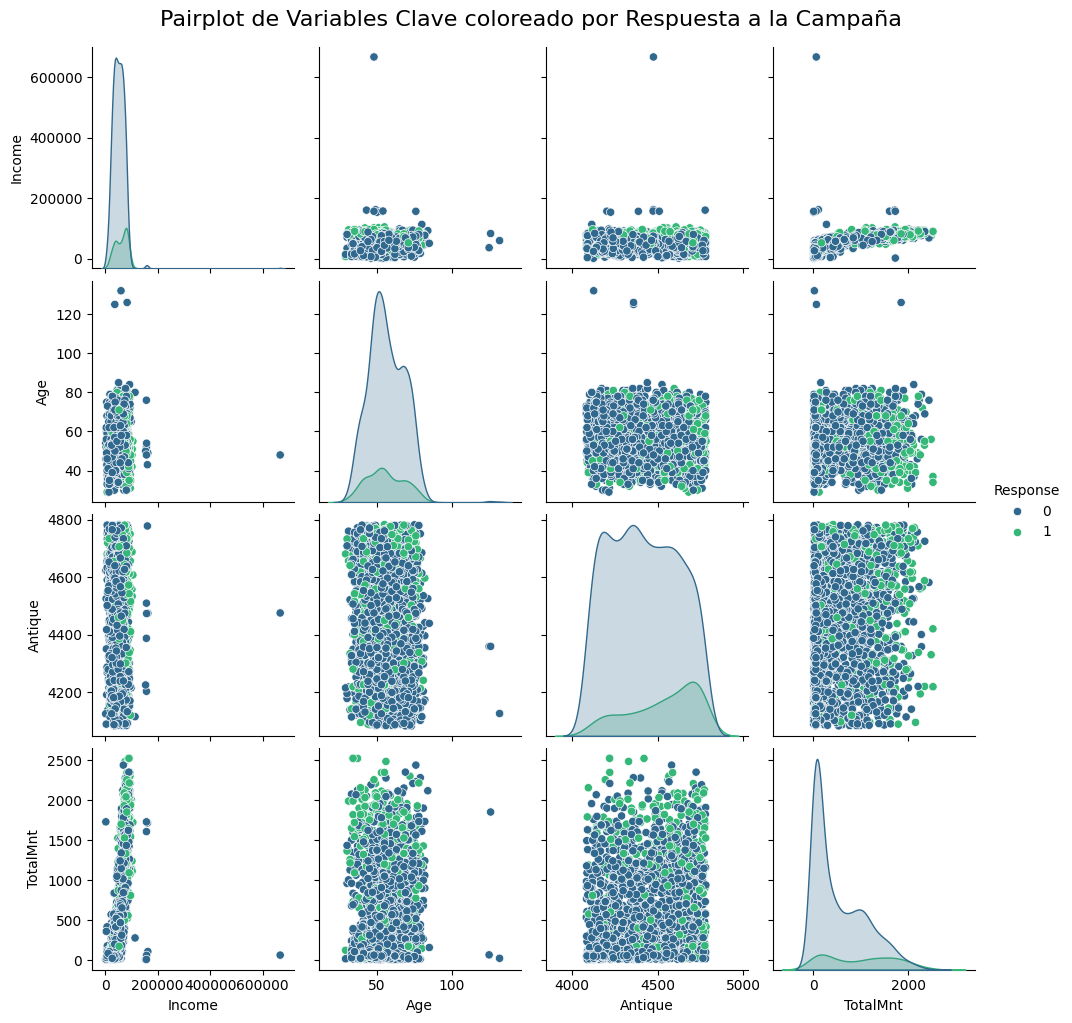

In [84]:
# Pregunta 1: ¿Cómo se distribuyen los datos en las variables clave? ¿Existen outliers que podrían distorsionar el análisis?

# Resumen estadístico de las variables
variables_eda = ['Income', 'Age', 'Antique', 'TotalMnt', 'Response']
print("\nResumen estadístico de variables clave:")
print(df[variables_eda].describe())

# Crear el pairplot
sns.pairplot(df[variables_eda], hue='Response', palette='viridis')
plt.suptitle('Pairplot de Variables Clave coloreado por Respuesta a la Campaña', y=1.02, fontsize=16)
plt.show()

Hay algunos valores "extraños" que podrían distorsionar nuestros análisis, los eliminaremos usando el método IQR

Dimensión inicial del DataFrame: (2030, 7)
Dimensión después de eliminar outliers en 'Income': (2022, 7)
Dimensión después de eliminar outliers en 'Age': (2019, 7)
Dimensión después de eliminar outliers en 'Antique': (2019, 7)
Dimensión después de eliminar outliers en 'TotalMnt': (2016, 7)


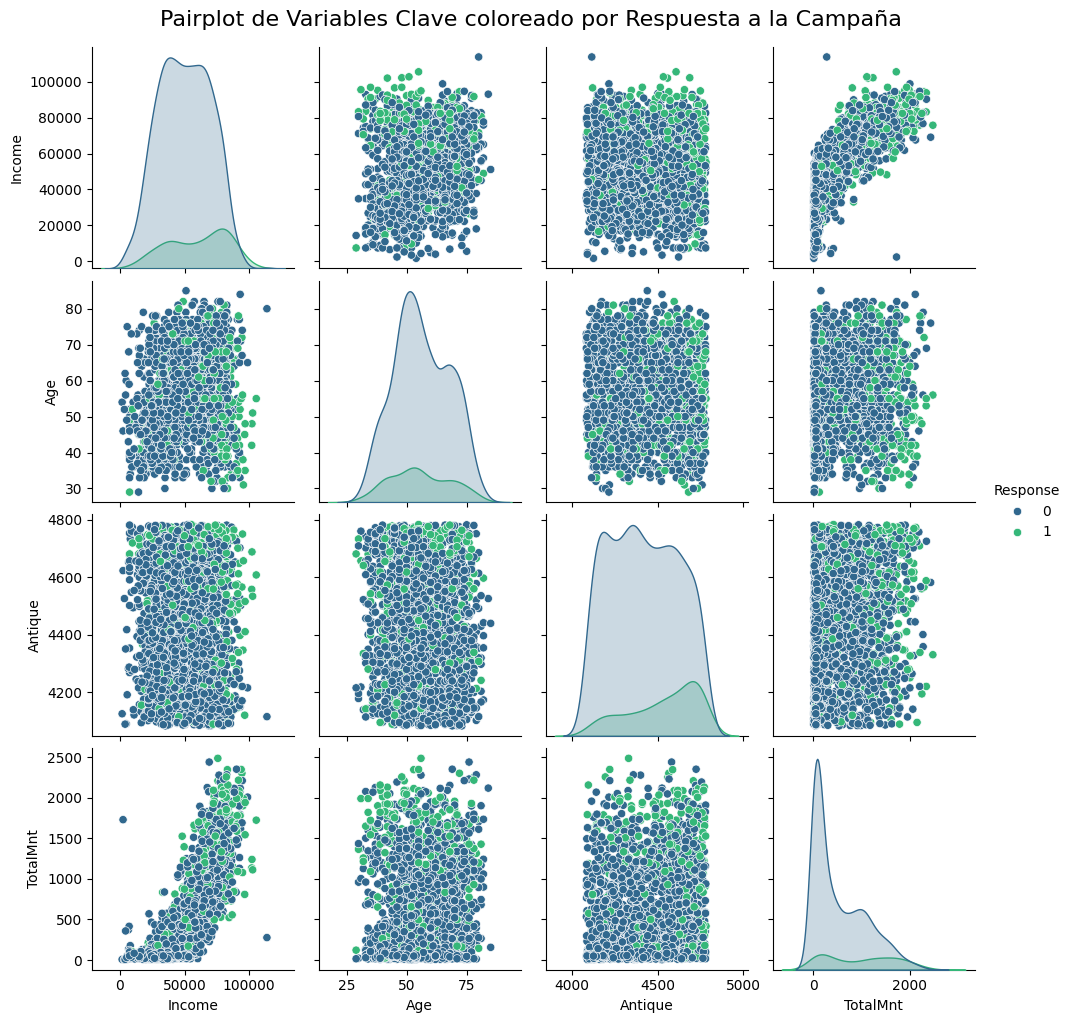

Análisis:
Al quitar los outliers se pueden apreciar algunas relaciones


In [85]:
# Definimos la función para eliminar outliers usando el método IQR
def remove_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Se utiliza una copia para evitar el SettingWithCopyWarning
    return dataframe[(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)].copy()

# Aplicar la función a cada una de las columnas
print("Dimensión inicial del DataFrame:", df.shape)

# Eliminar outliers de 'Income'
df = remove_outliers_iqr(df, "Income")
print("Dimensión después de eliminar outliers en 'Income':", df.shape)

# Eliminar outliers de 'Age'
df = remove_outliers_iqr(df, "Age")
print("Dimensión después de eliminar outliers en 'Age':", df.shape)

# Eliminar outliers de 'Antique'
df = remove_outliers_iqr(df, "Antique")
print("Dimensión después de eliminar outliers en 'Antique':", df.shape)

# Eliminar outliers de 'TotalMnt'
df = remove_outliers_iqr(df, "TotalMnt")
print("Dimensión después de eliminar outliers en 'TotalMnt':", df.shape)

# Crear el pairplot
sns.pairplot(df[variables_eda], hue='Response', palette='viridis')
plt.suptitle('Pairplot de Variables Clave coloreado por Respuesta a la Campaña', y=1.02, fontsize=16)
plt.show()

# Análisis de la pregunta
print("Análisis:")
print("Al quitar los outliers se pueden apreciar algunas relaciones")

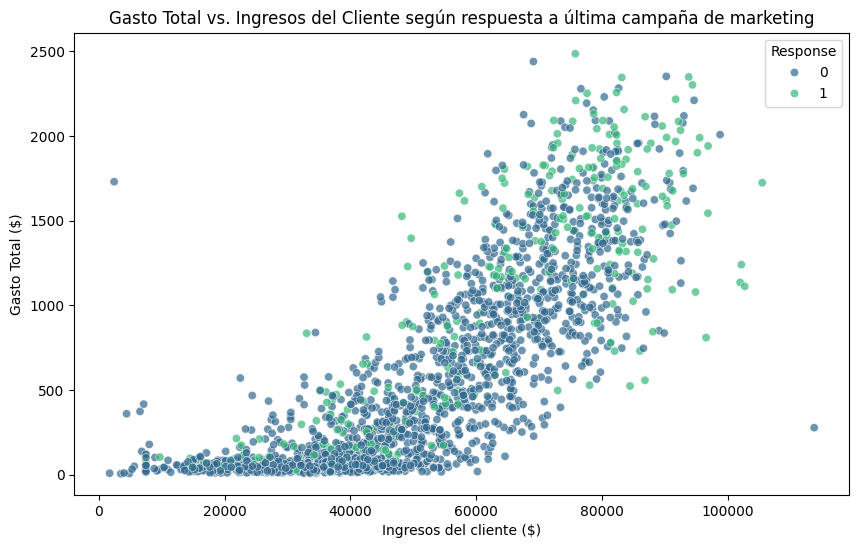

Análisis:
Hay una correlación lineal fuerte entre los ingresos del cliente y el gasto total. Lo cual confirma que a mayores ingresos, se genera un mayor gasto. Los clientes que respondieron a la última campaña parecen ganar y gastar más que los que no respondieron.


In [86]:
# Pregunta 2: ¿Cómo se se relacionan los ingresos de los clientes (Income) con el gasto (TotalMnt) y la respuesta a la última campaña (Response)?

# Gráfico de dispersión de Income vs TotalMnt
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Income', y='TotalMnt', data=df, hue='Response', palette='viridis', alpha=0.7)
plt.title('Gasto Total vs. Ingresos del Cliente según respuesta a última campaña de marketing')
plt.xlabel('Ingresos del cliente ($)')
plt.ylabel('Gasto Total ($)')
plt.show()

# Análisis de la pregunta
print("Análisis:")
print("Hay una correlación lineal fuerte entre los ingresos del cliente y el gasto total. Lo cual confirma que a mayores ingresos, se genera un mayor gasto. Los clientes que respondieron a la última campaña parecen ganar y gastar más que los que no respondieron.")

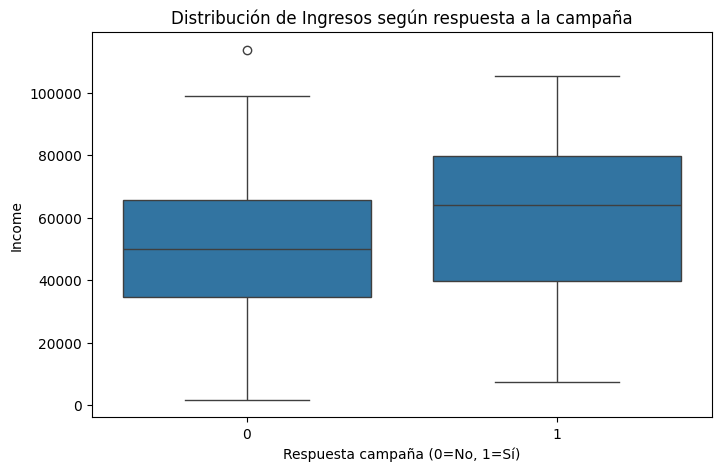

Análisis:
Los ingresos de los clientes que respondieron la campaña de son superiores a los que no respondieron


In [87]:
# PREGUNTA 3: ¿Cómo se distribuyen los ingresos de los clientes en base a su respuesta a la última campaña de marketing?

plt.figure(figsize=(8,5))
sns.boxplot(x=df["Response"], y=df["Income"])
plt.title("Distribución de Ingresos según respuesta a la campaña")
plt.xlabel("Respuesta campaña (0=No, 1=Sí)")
plt.show()

# Análisis de la pregunta
print("Análisis:")
print("Los ingresos de los clientes que respondieron la campaña de son superiores a los que no respondieron")

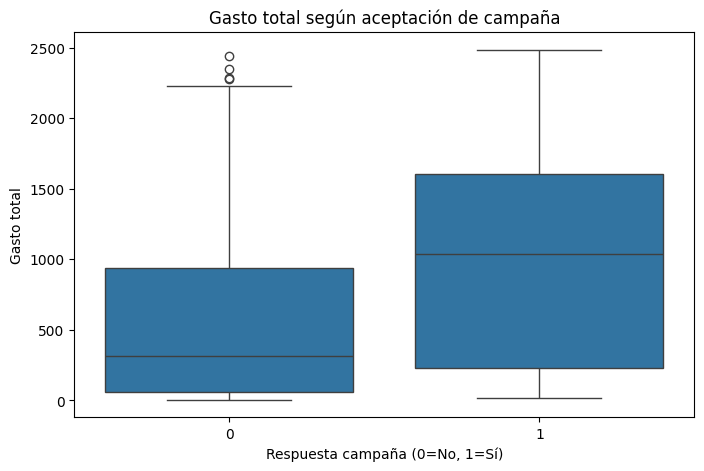

Análisis:
Los gastos de los clientes que respondieron la campaña son superiores a los que no respondieron


In [88]:
# PREGUNTA 4: ¿Cómo se distribuyen los gastos de los clientes en base a su respuesta a la última campaña de marketing?

plt.figure(figsize=(8,5))
sns.boxplot(x=df["Response"], y=df["TotalMnt"])
plt.title("Gasto total según aceptación de campaña")
plt.xlabel("Respuesta campaña (0=No, 1=Sí)")
plt.ylabel("Gasto total")
plt.show()

# Análisis de la pregunta
print("Análisis:")
print("Los gastos de los clientes que respondieron la campaña son superiores a los que no respondieron")

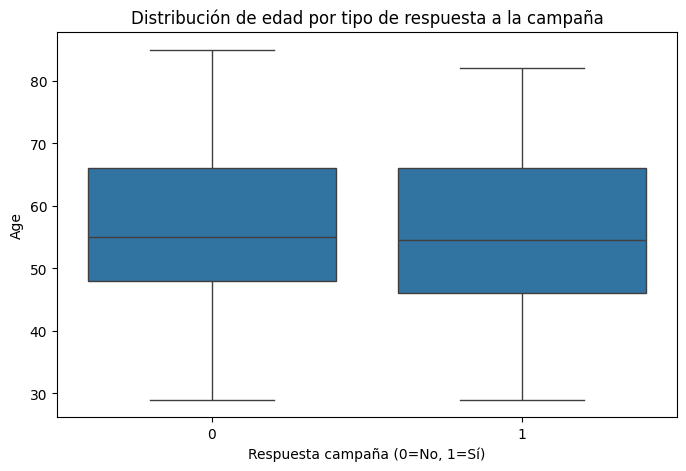

Análisis:
Los clientes son principalmente adultos entre los 45 y y los 70 años. Hay poca diferencia en la composición de edad de los grupos que respondieron y no respondieron a la última campaña de marketing


In [89]:
# PREGUNTA 5: ¿Cómo se distribuye la edad de los clientes según su respuesta a la última campaña y qué segmentos predominan?

plt.figure(figsize=(8,5))
sns.boxplot(x=df["Response"], y=df["Age"])
plt.title("Distribución de edad por tipo de respuesta a la campaña")
plt.xlabel("Respuesta campaña (0=No, 1=Sí)")
plt.show()

# Análisis de la pregunta
print("Análisis:")
print("Los clientes son principalmente adultos entre los 45 y y los 70 años. Hay poca diferencia en la composición de edad de los grupos que respondieron y no respondieron a la última campaña de marketing")

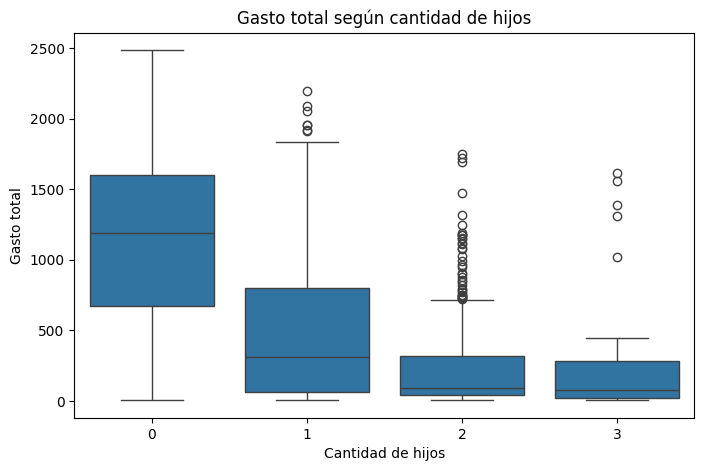

Análisis:
Las personas sin hijos tienen un gasto total mayor que quienes no. A mayor cantidad de hijos, menor es el gasto


In [90]:
# PREGUNTA 6: ¿Cómo se distribuyen los gastos de los clientes en base a su cantidad de hijos?

plt.figure(figsize=(8,5))
sns.boxplot(x=df["Children"], y=df["TotalMnt"])
plt.title("Gasto total según cantidad de hijos")
plt.xlabel("Cantidad de hijos")
plt.ylabel("Gasto total")
plt.show()

# Análisis de la pregunta
print("Análisis:")
print("Las personas sin hijos tienen un gasto total mayor que quienes no. A mayor cantidad de hijos, menor es el gasto")

# 3. Preparación de datos para ML. Encodig y Normalizacipón.

✅ **Explicación:**

En el anáisis exploratorio pudimos ver que la campaña de marketing tiene un efecto positivo sobre el nivel de gasto total, por lo que podemos decir que la última campaña de marketing ha sido efectiva.

Ahora, queremos intentar predecir el nivel de gastos (TotalMnt) de un cliente en base a sus Ingresos (Income), Respuesta a la campaña de marketing (Response), Edad (Age), Antiguedad como cliente (Antique), cantidad de hijos(Children) y Nivel de educación (Education)

En primer lugar necesitamos definir categorias de nivel de gasto que queremos predecir. En este caso, tras revisar la distribución de gastos se decidió establecer 3 categorias. De 0 a 100 será "Low", de 100 a 1000 será "Medium" y de 1000 en adelante será "High".

Las variables númericas "Income", "Response", "Age", "Antique", "Children" y "TotalMnt" serán normalizadas.

El nivel de educación (Education) será transformado a variables binarias para poder ser utilizada en los modelos de clustering y predicción.

In [91]:
# Crear categorias para Gasto total basandonos en los rangos encontrados en el análisis exploratorio

Spent_Bins = [0, 100, 1000, 2500]
Spent_Labels = ['Low', 'Medium', 'High']
df['SpentLvl'] = pd.cut(df['TotalMnt'], bins=Spent_Bins, labels=Spent_Labels, include_lowest=True)
df.value_counts(['TotalMnt', 'SpentLvl'], normalize=True, sort=False, dropna=True)
df.value_counts('SpentLvl', normalize=True, sort=False, dropna=True)


,proportion
SpentLvl,
Low,0.317460
Medium,0.414683
High,0.267857


In [92]:
# Seleccionar las columnas categóricas para codificarlas en categorias de valores binarios
categorical_cols = ['Education']

# Inicializar OneHotEncoder con la opción de manejar categorías desconocidas
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Ajustar y transformar los datos categóricos
encoded_data = encoder.fit_transform(df[categorical_cols])

# Obtener los nombres de las nuevas columnas
encoded_columns = encoder.get_feature_names_out(categorical_cols)

# Crear un DataFrame con los datos codificados
encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns)

# Unir el DataFrame original con el DataFrame codificado
df = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

df.head(5)

,Income,Response,Age,Antique,Children,TotalMnt,SpentLvl,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD
0,58138.0,1.0,68.0,4747.0,0.0,1617.0,High,0.0,0.0,1.0,0.0,0.0
1,46344.0,0.0,71.0,4197.0,2.0,27.0,Low,0.0,0.0,1.0,0.0,0.0
2,71613.0,0.0,60.0,4396.0,0.0,776.0,Medium,0.0,0.0,1.0,0.0,0.0
3,26646.0,0.0,41.0,4223.0,1.0,53.0,Low,0.0,0.0,1.0,0.0,0.0
4,58293.0,0.0,44.0,4245.0,1.0,422.0,Medium,0.0,0.0,0.0,0.0,1.0


In [93]:
# Selección de variables relevantes
features = ["Income","Age","Antique","Children","TotalMnt"]

# Escalamiento de las variables relevantes
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

df.head(5)

,Income,Response,Age,Antique,Children,TotalMnt,SpentLvl,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD
0,0.314670,1.0,1.017854,1.530675,-1.280529,1.692051,High,0.0,0.0,1.0,0.0,0.0
1,-0.255740,0.0,1.275426,-1.185747,1.402991,-0.966033,Low,0.0,0.0,1.0,0.0,0.0
2,0.966380,0.0,0.330994,-0.202896,-1.280529,0.286108,Medium,0.0,0.0,1.0,0.0,0.0
3,-1.208422,0.0,-1.300297,-1.057335,0.061231,-0.922568,Low,0.0,0.0,1.0,0.0,0.0
4,0.322166,0.0,-1.042725,-0.948678,0.061231,-0.305692,Medium,0.0,0.0,0.0,0.0,1.0


In [94]:
# Finalmente, eliminamos los datos que puedan contener valores nulos tras la limpieza

df= df.dropna()
df.shape

(1833, 12)

# 4. Segmentación de clientes

✅ **Explicación:**

Tras preparar los datos buscaremos segmentar en grupos a los clientes, para de esta manera, contar con un "perfil" asociado a el nivel de gasto.

Se decidió realizar la clusterización por medio de Kmeans, ya que tras graficar la variación con el metodo del "Codo", se encontraron 3 segmenton bien diferenciados, los que seria posible abordar con campañas de marketing diferenciadas o generar ofertas o planes de fidelización que sean mas apropiados para ellos.

Esta es una descripción general de los segmentos encontrados:

**Cluster 0**: Clientes que tienen el mayor promedio de ingresos y de gasto total, ellos son mayores en edad que los otros grupos y tienen menos niños. Este grupo representa a clientes fidelizados.

**Cluster 1**: Este grupo tiene un promedio menor de ingresos y gasto total. Son los clientes que tienen más hijos y que también son mayores. Este grupo representa a familias con menores ingresos.

**Cluster 2:** Este grupo tienen ingresos y gastos moderados y son los mas jovenes y tienen pocos hijos. Este grupo puede representar a familias jovenes o individuos que están en etapas tempranas de sus carreras.

In [95]:
# Definimos el set de datos para realizar la clusterización quitando el valor base (TotalMnt) y el valor categorizado (SpentLvl) como variables predictoras

x = df.drop(columns=["SpentLvl", "TotalMnt"])
y = df["SpentLvl"]

x.shape

(1833, 10)

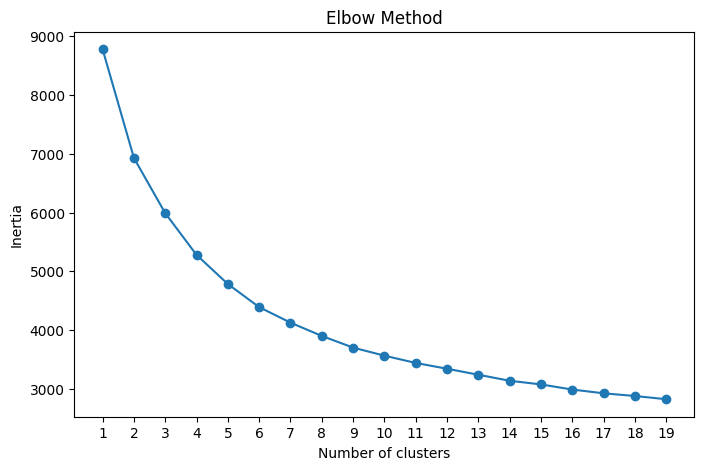

In [96]:
# Aplicamos el método del "codo" para revisar la perdida de variación según cantidad de clusters

inertias = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(x)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 20), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 20))
plt.show()

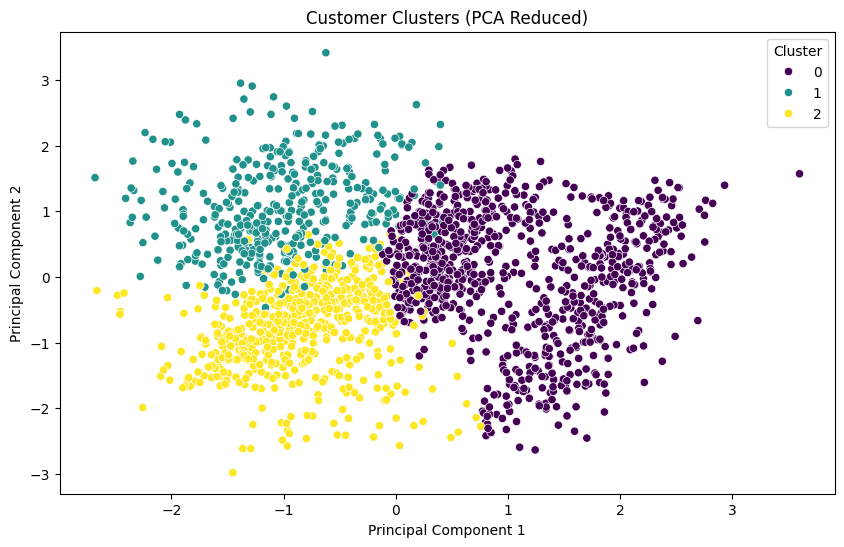

In [97]:
# Aplicar KMeans con 3 Clusters
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10)
clusters = kmeans.fit_predict(x)

# Agregar el numero de cluster al dataframe
df['Cluster'] = clusters

# Usar PCA para reducir la dimensionalidad para un gráfico sencillo en 2D
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
pca_df = pd.DataFrame(data = principal_components, columns = ['principal component 1', 'principal component 2'])

# Agregar el valor del Cluster al dataframe con PCA
pca_df['Cluster'] = clusters

# Visualizar los clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='principal component 1', y='principal component 2', hue='Cluster', data=pca_df, palette='viridis', legend='full')
plt.title('Customer Clusters (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [98]:
# Revisar las caracteristicas de cada cluster:
cluster_characteristics = df.groupby('Cluster')[features].mean()
display(cluster_characteristics)

,Income,Age,Antique,Children,TotalMnt
Cluster,,,,,
0,0.813194,0.348267,0.010969,-0.619970,0.772069
1,-0.331140,0.353373,-0.078284,1.463521,-0.583797
2,-0.922165,-0.750751,0.038634,-0.134679,-0.697466


# 5. Predicción de segmento para clientes nuevos

✅ **Explicación:**

Ya sabemos que dentro de los clientes existen por lo menos 3 grupos bien diferenciados. Esto nos puede ayudar a saber como llegar mejor a ellos, según sus caracteristicas y necesidades. Esto puede ser muy aplicable para clientes antiguos.

Cuando tengamos un cliente nuevo, no sabremos a que segmento pertenece, pero podemos generar un modelo que utilice la información disponible para intentar predecirlo y poder ajustar el tipo de publicidad que le haremos.

Como se trata de un cliente nuevo, no consideraremos el Gasto (TotalMnt y SpendLvl), ni la respuesta a las campañas de marketing (Response) ni la antiquedad (Antique).

Dada la naturaleza de los datos y la posibilidad de optimización, se utilizó RandomForestClassifier y buscamos con Grid Search los mejores hiperparametros para ajustar el modelo, logrando obtener un nivel de precisión de casi 98% para el mejor modelo en el set de prueba.

Además al realizar la comparación con presición del set de entrenamiento con el de test, podemos verificar que no existe Overfitting.

El metodo RandomForest es efectivo a la hora de probar, comparar y explicar modelos.


In [99]:
df.head(5)

,Income,Response,Age,Antique,Children,TotalMnt,SpentLvl,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Cluster
0,0.314670,1.0,1.017854,1.530675,-1.280529,1.692051,High,0.0,0.0,1.0,0.0,0.0,0
1,-0.255740,0.0,1.275426,-1.185747,1.402991,-0.966033,Low,0.0,0.0,1.0,0.0,0.0,1
2,0.966380,0.0,0.330994,-0.202896,-1.280529,0.286108,Medium,0.0,0.0,1.0,0.0,0.0,0
3,-1.208422,0.0,-1.300297,-1.057335,0.061231,-0.922568,Low,0.0,0.0,1.0,0.0,0.0,2
4,0.322166,0.0,-1.042725,-0.948678,0.061231,-0.305692,Medium,0.0,0.0,0.0,0.0,1.0,2


In [100]:
# Preparación de datos para la predicción

X = df.drop(columns=['Response', 'TotalMnt', 'Antique', 'SpentLvl', 'Cluster'])
y = df['Cluster']

In [101]:
# Separación de datos en set de entrenamiento y validación

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (1466, 8)
X_test shape: (367, 8)
y_train shape: (1466,)
y_test shape: (367,)


In [102]:
# Definición de hiperparametros a probar con GridSearch:

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}

In [103]:
# Se instancia RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

# Se instancia GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)

# Se ajusta el objeto GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Se impriment los mejores parametros
print("Los mejores hiperparametros para los modelos de RandomForest encontrados por GridSearchCV son:")
print(grid_search.best_params_)

Los mejores hiperparametros para los modelos de RandomForest encontrados por GridSearchCV son:
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300}


In [104]:
# Se instancia el mejor modelo
best_model = grid_search.best_estimator_

# Predicciones en el set de prueba
y_pred = best_model.predict(X_test)

# Predicciones en el set de entrenamiento
y_train_pred = best_model.predict(X_train)

# Calculo de accuracy en el set de entrenamiento
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)

# Reporte de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       170
           1       0.99      0.99      0.99        72
           2       0.98      0.95      0.97       125

    accuracy                           0.98       367
   macro avg       0.98      0.98      0.98       367
weighted avg       0.98      0.98      0.98       367

Training Accuracy: 1.0000
Testing Accuracy: 0.9782


# 6. Conclusiones


✅ **Explicación:**

 Se generó un modelo de predicción de segmento de clientes robusto con un margen de mejora bastante acotado que sirve para establecer que tipo de estrategia comunicacional o de marketing realizar a nuevos clientes.

Se dividió la data en set de entrenamiento y test, con 1466 datos de entrenamiento y 637 de prueba.

Se probaron disintos hiperparametros para el RandomForestClassifier por medio de
GridSearchCV que encontró que los mejores fueron : {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300}. Este modelo clasificó correctamente cerca del 98% de los casos del set de testeo.

 La matriz de confusión muestra que hay muy pocos casos que resultan mal clasificados, sería interesante revisar estos para explorar relaciones no abordadas en este análisis.

 El análisis de importancia de las features señala que las variables que aportan mayor fuerza a la predicción son los ingresos (Income), el número de hijos (Children) y la edad (Age).

 Dado los altos resultados en la presición del modelo, no se consideró utilizar tecnicas de reducción de dimensionalidad.


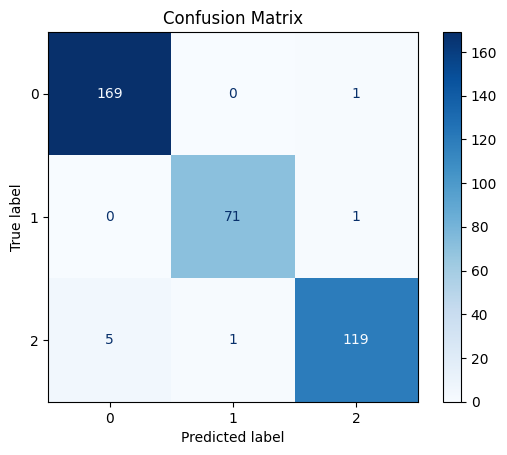

In [105]:
# Generar la matriz de confusión:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues') # Added cmap='Blues'
disp.ax_.set_title('Confusion Matrix')
plt.show()

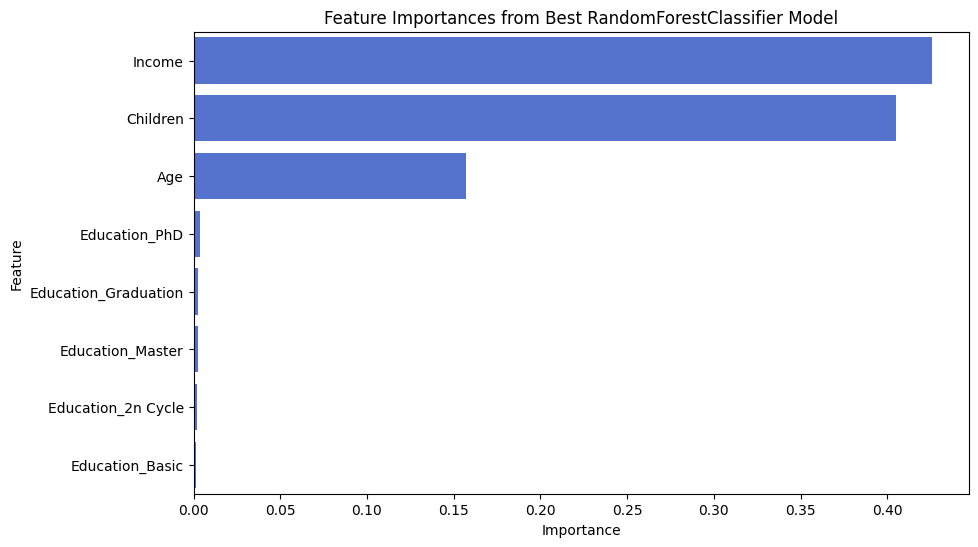

In [106]:
# Obtener la importancia de las features
feature_importances = best_model.feature_importances_

feature_importances_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
})
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances_df, color='royalblue')
plt.title('Feature Importances from Best RandomForestClassifier Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()